In [134]:
"""The first block includes all the necessary imports for the code. You're importing libraries to load and manipulate images (cv2, PIL), to process and visualize data (numpy, pandas, seaborn, matplotlib),
 to build and train a neural network model (tensorflow), and others (sklearn, os, IPython, warnings) to provide additional functionality.
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings



In [ ]:
#The link of the data we use in this project: https://www.kaggle.com/datasets/amanrajbose/normal-vs-military-vehicles

In [135]:
#The next block defines two classes that will be used in classification (military and other) and the size of images to be used in the model.
labels = ['millitary','other']
img_size = 32

In [136]:
#The next block defines two classes that will be used in classification (military and other) and the size of images to be used in the model.
path_of_train = os.path.join('dataset','train')
path_of_validation = os.path.join('dataset','validation')
path_of_test = os.path.join('dataset','test')

X_train = []
Y_train = []


In [137]:
#Next, you read the images from the dataset, resize them to the specified size, and assign the label based on the directory name. You also encode your labels (from categorical to numerical).
for i in labels:
    train_path = os.path.join(path_of_train,i)
    validation_path = os.path.join(path_of_validation,i)
    test_path = os.path.join(path_of_test,i)
    for j in os.listdir(train_path):
        img = cv2.imread(os.path.join(train_path,j))
        img = cv2.resize(img,(img_size,img_size))
        X_train.append(img)
        Y_train.append(i)
    for j in os.listdir(validation_path):
        img = cv2.imread(os.path.join(validation_path,j))
        img = cv2.resize(img,(img_size,img_size))
        X_train.append(img)
        Y_train.append(i)
    for j in os.listdir(test_path):
        img = cv2.imread(os.path.join(test_path,j))
        img = cv2.resize(img,(img_size,img_size))
        X_train.append(img)
        Y_train.append(i)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)





In [160]:
#Then, you define an ImageDataGenerator, which is a keras utility to automatically create a batch of images with real-time data augmentation.
datagen = ImageDataGenerator(
    rotation_range=20,     
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,       
    zoom_range=0.2,        
    horizontal_flip=True,  
    fill_mode='nearest'    
)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [139]:
#The next block is for normalization, you divide the pixel values by 255 to scale them to the range [0,1]. This helps with the training of the neural network.
X_train = X_train / 255.0

In [140]:
datagen.fit(X_train)


In [141]:
X_train.shape,Y_train.shape

((17453, 32, 32, 3), (17453,))

In [142]:
#Then, you split the data into training and test sets using the train_test_split method from sklearn.
x_train,x_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=20)

In [143]:
from keras.layers import Conv2D,Dropout,Dense,Activation,MaxPool2D,Flatten
from keras.models import Sequential
model = Sequential() # Initializing Sequential model

# Add a 2D convolution layer with 32 output filters, each with a kernel size of 3x3. The activation function is 'relu' 
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_size,img_size,3)))

# Max Pooling layer to reduce the spatial dimensions (width, height) of the input volume.
model.add(MaxPool2D((2,2)))

# Adding another convolution layer with 64 output filters.
model.add(Conv2D(64,(3,3),activation='relu'))

# Adding another Max Pooling layer.
model.add(MaxPool2D((2,2)))

# Flatten layer to convert the 2D matrix data to a 1D array.
model.add(Flatten())

# Fully connected layer (Dense layer) with 128 nodes.
model.add(Dense(128,activation='relu'))

# Output layer with 1 node. 'sigmoid' function is used for binary classification.
model.add(Dense(1,activation='sigmoid')) 


In [144]:
#Next, you compile your model specifying the optimizer, loss function, and metrics to monitor.
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['Accuracy'])

In [145]:
#After that, you define the callbacks. Callbacks are used to monitor training and stop or save the model when certain conditions are met.
tensorboard = TensorBoard(log_dir='military_logs')
checkpoint = ModelCheckpoint('military_other.h5',monitor='val_accuracy',save_best_only=True,
                             mode = "auto",verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.3,patience=2,min_delta=0.001,
                              mode = 'auto',verbose = 1)

In [146]:
#hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=25)
#Then, you train the model using the training data.
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) / 32, 
          validation_data=datagen.flow(x_test, y_test),
          epochs=25)


Epoch 1/25


C:\Users\Eray\AppData\Local\Temp\ipykernel_20668\556116983.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),


436/436 [==============================] - 6s 13ms/step - loss: 0.5205 - Accuracy: 0.7323 - val_loss: 0.4611 - val_Accuracy: 0.7949
Epoch 2/25
436/436 [==============================] - 6s 13ms/step - loss: 0.4366 - Accuracy: 0.8018 - val_loss: 0.4496 - val_Accuracy: 0.7786
Epoch 3/25
436/436 [==============================] - 7s 16ms/step - loss: 0.4085 - Accuracy: 0.8156 - val_loss: 0.3884 - val_Accuracy: 0.8324
Epoch 4/25
436/436 [==============================] - 6s 14ms/step - loss: 0.3837 - Accuracy: 0.8285 - val_loss: 0.3826 - val_Accuracy: 0.8324
Epoch 5/25
436/436 [==============================] - 6s 13ms/step - loss: 0.3755 - Accuracy: 0.8320 - val_loss: 0.3536 - val_Accuracy: 0.8502
Epoch 6/25
436/436 [==============================] - 6s 13ms/step - loss: 0.3604 - Accuracy: 0.8424 - val_loss: 0.3363 - val_Accuracy: 0.8542
Epoch 7/25
436/436 [==============================] - 6s 13ms/step - loss: 0.3368 - Accuracy: 0.8545 - val_loss: 0.3234 - val_Accuracy: 0.8662
Epoch 8/25

In [154]:
#After training, you save the model and its weights.
model.save('military_epoch25.h5')
model.save_weights('military_epoch25_weights.h5')

In [148]:
hist.history

{'loss': [0.5204628705978394,
  0.43656831979751587,
  0.40853047370910645,
  0.38365522027015686,
  0.3755180835723877,
  0.36043819785118103,
  0.33680444955825806,
  0.3319565951824188,
  0.31259745359420776,
  0.30554690957069397,
  0.2911415100097656,
  0.2953915596008301,
  0.28701698780059814,
  0.2748717963695526,
  0.26648595929145813,
  0.26872721314430237,
  0.25610750913619995,
  0.25004875659942627,
  0.24432629346847534,
  0.24228627979755402,
  0.24149192869663239,
  0.23229075968265533,
  0.21703946590423584,
  0.2211081087589264,
  0.21462251245975494],
 'Accuracy': [0.732344925403595,
  0.8018192052841187,
  0.8156424760818481,
  0.8285346031188965,
  0.8320441246032715,
  0.8423578143119812,
  0.8544620871543884,
  0.8536026477813721,
  0.8683569431304932,
  0.8674975037574768,
  0.8783841729164124,
  0.8730840682983398,
  0.8765935897827148,
  0.8836126923561096,
  0.8889127373695374,
  0.8851167559623718,
  0.8913479447364807,
  0.8970061540603638,
  0.897937238216

In [149]:
#prediction
pred = model.predict(x_test)

110/110 [==============================] - 1s 4ms/step


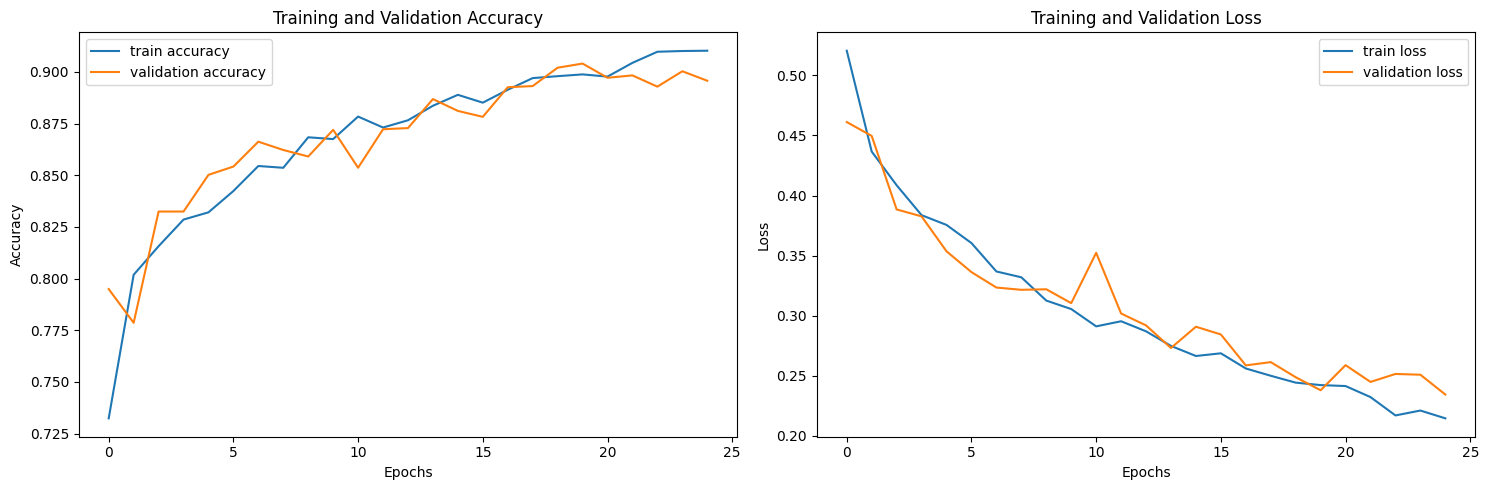

In [162]:
#Then, you plot the accuracy and loss for the training and validation data to monitor the training process.
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(hist.history['Accuracy'], label='train accuracy')
plt.plot(hist.history['val_Accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

   millitary       0.97      0.77      0.86      1569
       other       0.84      0.98      0.90      1922

    accuracy                           0.89      3491
   macro avg       0.90      0.88      0.88      3491
weighted avg       0.90      0.89      0.88      3491



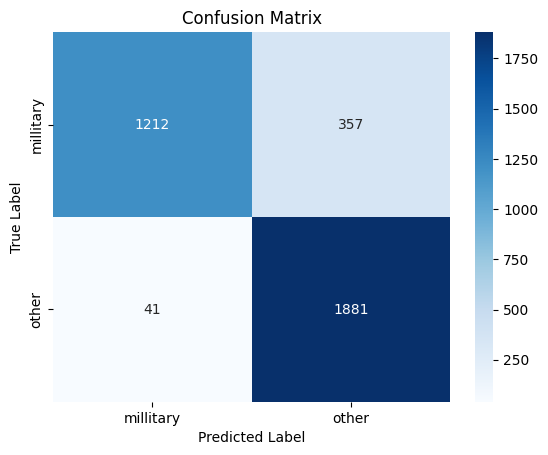

In [161]:
#Next, you predict the class labels for the test data.
pred = np.round(pred)

# Classification report
#Finally, you print a classification report that shows the main classification metrics, and a confusion matrix that visualizes the performance of the classification algorithm.
print("Classification Report:\n", classification_report(y_test, pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()





#All of this code aims to classify images into two categories (military and others) using a simple convolutional neural network with image augmentation and real-time data preprocessing.
